In [1]:
import os
import pandas as pd

import seaborn as sns
from seaborn import plt
#sns.set_style('white')

%matplotlib inline

### Load data

Option A: copy/paste

In [2]:
authors = pd.read_csv('../data/processed/authors.csv')
books = pd.read_csv('../data/processed/books.csv')

Option B: write a function!

In [3]:
def get_data(csv_name, directory='processed'):
    '''Returns df of csv; defaults to processed data directory'''
    path = os.path.join(os.pardir, 'data', directory, csv_name)
    return pd.read_csv(path)

In [4]:
authors = get_data('authors.csv')
books = get_data('books.csv')

### Tables

In [5]:
list(authors.columns)

['a_id',
 'a_fans_count',
 'a_works_count',
 'gender',
 'hometown',
 'a_avg_rating',
 'a_ratings_count',
 'a_text_reviews_count',
 'author',
 'a_wks_on_list',
 'a_books_on_list']

In [6]:
list(books.columns)

['b_id',
 'gr_title',
 'nyt_title',
 'b_count',
 'pub_yr',
 'b_avg_rating',
 'b_ratings_count',
 'b_txt_rev_count',
 'publisher',
 'b_rating_5_count',
 'b_rating_4_count',
 'b_rating_3_count',
 'b_rating_2_count',
 'b_rating_1_count',
 'b_wks_on_list',
 'decade',
 'a_id']

Top 10 authors with highest number of weeks on the NYT list (could be multiple books)

In [7]:
authors.sort_values('a_wks_on_list', ascending=False)[['author', 'a_wks_on_list']].head(10)

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


In [8]:
def top_ten(df, column, index=True):
    '''Returns 10 highest values of df.column'''
    if index != True:
        df = df.set_index(index)
    return df.sort_values(column, ascending=False)[column].head(10)

In [9]:
top_ten(authors, 'a_wks_on_list')

67     200.0
126    144.0
128    139.0
92     102.0
226     94.0
236     91.0
153     81.0
238     77.0
101     75.0
127     74.0
Name: a_wks_on_list, dtype: float64

In [10]:
top_ten(authors, 'a_wks_on_list', index='author')

author
James A. Michener    200.0
Stephen King         144.0
John Grisham         139.0
James Patterson      102.0
Danielle Steel        94.0
Herman Wouk           91.0
Robert Ludlum         81.0
John le Carré         77.0
Dan Brown             75.0
Tom Clancy            74.0
Name: a_wks_on_list, dtype: float64

In [11]:
top_ten(books, 'b_wks_on_list')

325    59
254    49
496    48
661    46
472    41
247    40
678    38
551    38
391    36
84     34
Name: b_wks_on_list, dtype: int64

In [12]:
top_ten(books, 'b_wks_on_list', 'nyt_title')

nyt_title
The Da Vinci Code                    59
Hawaii                               49
The Caine Mutiny                     48
The Robe                             46
Love Story                           41
The Source                           40
The Bridges of Madison County        38
Jonathan Livingston Seagull          38
Trinity                              36
The Spy Who Came in from the Cold    34
Name: b_wks_on_list, dtype: int64

In [13]:
top_ten(books.groupby('decade').count(), 'nyt_title')

decade
2000s    217
2010s    194
1990s    100
1980s     78
1970s     45
1940s     44
1950s     33
1960s     31
Name: nyt_title, dtype: int64

In [14]:
top_ten(books.groupby('publisher').mean(), 'b_avg_rating')

publisher
DAW Books                 4.570
Open Road Media           4.530
Scholastic                4.520
Roc                       4.495
Amy Einhorn Books         4.450
Arthur A. Levine Books    4.430
Crown                     4.390
Scholastic Inc.           4.360
Amereon Limited           4.340
Piatkus                   4.290
Name: b_avg_rating, dtype: float64

In [15]:
top_ten(books.groupby('publisher').count(), 'nyt_title')

publisher
Unknown                     147
Little Brown & Co            48
Berkley                      43
Bantam                       33
G.P. Putnam's                29
Grand Central Publishing     28
Harper Collins               19
Random House                 18
Warner                       17
Pocket                       16
Name: nyt_title, dtype: int64

In [16]:
top_ten(authors, 'a_works_count', 'author')

author
Agatha Christie        1905
Stephen King           1260
Neil Gaiman            1062
George R.R. Martin      744
Nora Roberts            652
W. Somerset Maugham     560
Ernest Hemingway        543
James Patterson         498
Umberto Eco             483
Louis L'Amour           465
Name: a_works_count, dtype: int64

### Bar plots

Bar plot of weeks spent on list by gender

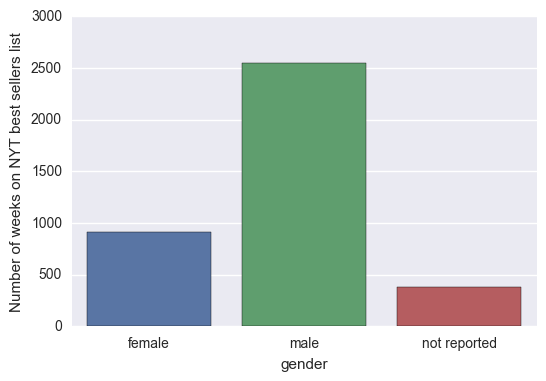

In [17]:
# df
wks_by_gender = authors.groupby('gender', as_index=False).sum()[['gender', 'a_wks_on_list']]
fig1 = sns.barplot(x='gender', y='a_wks_on_list', data=wks_by_gender)

# label y-axis
fig1.set(ylabel='Number of weeks on NYT best sellers list');

Bar plot of number of authors by gender

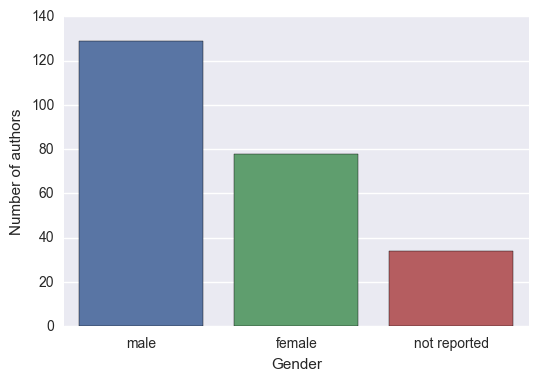

In [18]:
# series
authors_by_gender = authors['gender'].value_counts()
fig2 = sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values);

# label both axes
fig2.set(xlabel='Gender', ylabel='Number of authors');

Bar plot of top ten books by number of weeks on list

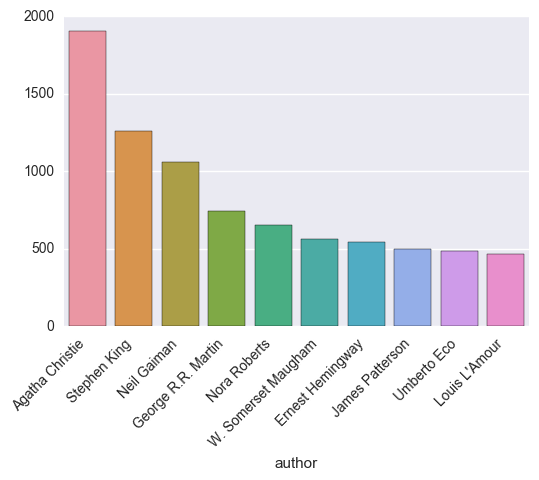

In [19]:
# series
top_ten_author_works = top_ten(authors, 'a_works_count', 'author')
sns.barplot(x=top_ten_author_works.index, y=top_ten_author_works.values)

# rotate long labels
plt.xticks(rotation=45)

# align labels with bars
plt.xticks(ha='right');

[Remove to improve (the data-ink ratio) by Darkhouse Analytics](http://www.darkhorseanalytics.com/blog/data-looks-better-naked)
* Remove backgrounds
* Remove redundant labels
* Remove borders
* Reduce colors
* Remove special effects
* Remove bolding
* Lighten labels
* Lighten or remove lines
* Add direct labels

In [30]:
fig1

In [20]:
# remove backgrounds
# remove redundant labels
# remove borders
# reduce colors
# remove special effects
# remove bolding
# lighten labels
# lighten or remove lines
# add direct labels

In [ ]:
def create_empty_fig(xlabel='', ylabel=''):
    '''Returns empty Tufte-style fig, ax objects'''
    # create figures and axes objects to modify
    fig, ax = plt.subplots(figsize=(8,6))

    # remove y axis tick labels
    ax.set_yticklabels([])

    # remove square outline
    ax.set_frame_on(False)
    
    # add labels for axes
    ax.set(xlabel=xlabel, ylabel=ylabel);
    
    return fig, ax

In [ ]:
def highlight_max(data, highlight, standard):
    '''Sets biggest value to highlight color'''
    return [standard if (x < max(data.values)) else highlight for x in data.values]

In [ ]:
def add_bar_labels(data, ax):
    '''Adds labels to tops of bars of sns barplot'''
    labels = data.values # label each bar with y value
    y_margin = max(labels) * 0.01
    for bar, label in zip(ax.patches, labels):
        #x location of label
        x = bar.get_x()
        bar_width = bar.get_width()
        center = x + bar_width/2.0

        #y location of label
        bar_height = bar.get_height()

        ax.text(x=center, y=bar_height + y_margin, s=label, ha='center')

In [ ]:
def highlighted_bar_chart(data, xlabel='', ylabel=''):
    # create empty fig, ax
    fig, ax = create_empty_fig(xlabel='Gender', ylabel='Number of authors')

    # draw plot bar
    # color palette
    highlight = '#4c4e2f'
    standard = '#a4a86f'

    colors = highlight_max(data, highlight, standard)
    sns.barplot(x=data.index, y=data.values, palette=colors)

    # add labels on top of bars
    add_bar_labels(data, ax)

In [ ]:
# create empty fig, ax
fig, ax = create_empty_fig(xlabel='Gender', ylabel='Number of authors')

# dataset is number of authors by gender
data = authors['gender'].value_counts()
print(data)

# draw plot bar
# color palette
highlight = '#4c4e2f'
standard = '#a4a86f'

colors = highlight_max(data, highlight, standard)
sns.barplot(x=data.index, y=data.values, palette=colors)

# add labels on top of bars
add_bar_labels(data, ax)

In [ ]:
# dataset is number of authors by gender
wks_by_gender = authors.groupby('gender').sum()['a_wks_on_list']
print(wks_by_gender)

highlighted_bar_chart(wks_by_gender, xlabel='Gender', ylabel='Number of weeks on list')

In [ ]:
# dataset is number of authors by gender
data = authors['gender'].value_counts()
print(data)

highlighted_bar_chart(data, xlabel='Gender', ylabel='Number of authors')

Histogram of numbers of weeks spent on list by author

In [ ]:
# create empty fig, ax
fig, ax = create_empty_fig(xlabel='Number of weeks on NYT list', ylabel='Number of authors')
sns.distplot(authors['a_wks_on_list'], kde=False);

In [ ]:
fig3 = sns.distplot(authors['a_wks_on_list'], kde=False)
fig3.set(xlabel='Number of weeks on NYT list', ylabel='Number of authors');

Histogram of number of books (total) by author.

In [ ]:
fig4 = sns.distplot(authors['a_works_count'], kde=False)
fig4.set(xlabel='Total number of works', ylabel='Number of authors');

Top 10 authors with highest number of total works

Histogram of number of books on NYT list by author.

In [ ]:
fig5 = sns.distplot(authors['a_books_on_list'], kde=False);
fig5.set(xlabel='Number of books on NYT list', ylabel='Number of authors');

Top 10 authors with highest number of books on NYT list

In [ ]:
authors.sort_values('a_books_on_list', ascending=False)[['author','a_books_on_list', 'a_wks_on_list']].head(10)

Histogram of average book rating

In [ ]:
authors['a_avg_rating'].mean()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_frame_on(False)
fig6 = sns.distplot(authors['a_avg_rating'], kde=True, color='#a4a86f');
fig6.set(xlabel='Average Rating', ylabel='Number of authors');

Author pairplots

In [ ]:
sns.pairplot(authors);

### Books EDA

In [ ]:
#calculate number of weeks each book was on NYT lists by year, by book, and by author
nyt_by_year = nyt.groupby(by=['title', 'author', 'year'], as_index=False).count()[['title', 'author', 'year', 'date']]

In [ ]:
#rename columns to be able to join nyt df with goodreads dfs
columns = {'title': 'nyt_title',
           'date': 'b_wks_on_list'}

nyt_by_year.rename(columns=columns, inplace=True)

Bar plot of total number of books per year

In [ ]:
nyt_by_year = nyt_by_year.groupby('year', as_index=False).count()[['year', 'nyt_title']]

In [ ]:
nyt_by_year.rename(columns={'nyt_title': 'num_of_books'}, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig7 = sns.barplot(x='year', y='num_of_books', data=nyt_by_year, ax=ax, color='#a4a86f')
fig7.set(ylabel='Number of books on NYT Bestseller List')
fig7.set(Xlabel='Year')
ax.set_frame_on(False)
fig7.set(yticklabels=[])
fig7.set(xticklabels=[]);

Bar plot of total books per decade

In [ ]:
books_by_decade = books.groupby('decade', as_index=False).count()[['decade', 'nyt_title']]
books_by_decade.rename(columns={'nyt_title': 'num_of_books'}, inplace=True)

In [ ]:
books_by_decade.loc[books_by_decade['decade']=='2010s', 'num_of_books'] = (194*10/7)

In [ ]:
194*10/7

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig8 = sns.barplot(x='decade', y='num_of_books', data=books_by_decade, ax=ax, color='#a4a86f')
fig8.set(ylabel='Number of books on NYT best sellers list')
fig8.set(xlabel='Decade')
ax.set_frame_on(False)
plt.xticks(rotation=0);

Bar plot of total books by publisher

In [ ]:
pub_counts = books.groupby('publisher', as_index=False).count()[['publisher', 'b_count']]
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books');

Bar plot of total books by publisher (without unknowns)

In [ ]:
#remove Unknown
pub_counts = pub_counts.drop(111)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig10 = sns.barplot(x='publisher', y='b_count', data=pub_counts, ax=ax)
fig10.set(xlabel='Publisher', ylabel='Number of books');
plt.xticks(rotation=45);

Bar plot of total books by publisher by decade (without unknowns)

In [ ]:
pub_counts_decades = books.groupby(['publisher', 'decade'], as_index=False).count()[['publisher', 'decade', 'b_count']]
decade = pub_counts_decades[pub_counts_decades['decade']=='2010s']
decade = decade[decade['b_count'] > 1]
decade = decade[decade['publisher'] != 'Unknown']
fig16 = sns.barplot(x='publisher', y='b_count', data=decade)
fig16.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

In [ ]:
pub_counts = books.groupby(['publisher', 'b_wks_on_list'], as_index=False).count()[['publisher', 'b_wks_on_list', 'b_count']]
pub_counts = pub_counts[pub_counts['b_wks_on_list'] == 1]
pub_counts = pub_counts[pub_counts['b_count'] > 5]
pub_counts = pub_counts[pub_counts['publisher'] != 'Unknown']
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

In [ ]:
pub_counts = books.groupby(['publisher', 'b_wks_on_list'], as_index=False).count()[['publisher', 'b_wks_on_list', 'b_count']]
pub_counts = pub_counts[pub_counts['b_wks_on_list'] > 1]
pub_counts = pub_counts[pub_counts['b_count'] > 1]
pub_counts = pub_counts[pub_counts['publisher'] != 'Unknown']
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

Histogram of number of weeks on NYT list by book

In [ ]:
len(books)

In [ ]:
float(len(books[books['b_wks_on_list']<7]))/len(books)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
#fig8 = sns.barplot(x='decade', y='num_of_books', data=books_by_decade, ax=ax, palette='RdBu')
#fig8.set(ylabel='Number of books on NYT best sellers list')
#fig8.set(xlabel='Decade')
ax.set_frame_on(False)
plt.xticks(rotation=0);

dark = '#4c4e2f'
light = '#a4a86f'

fig11 = sns.distplot(books['b_wks_on_list'], bins=60, kde=False, norm_hist=True, ax=ax, color=dark)
fig11.set(xlabel='Number of weeks on NYT list', ylabel='Number of books');

Top 10 books with longest run on NYT list

In [ ]:
books.sort_values('b_wks_on_list', ascending=False)[['nyt_title', 'author', 'decade', 'b_wks_on_list']].head(10)

Histogram of average book rating

In [ ]:
books['b_avg_rating'].mean()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_frame_on(False)
fig12 = sns.distplot(books['b_avg_rating'], kde=True, color='#a4a86f');
fig12.set(xlabel='Average Rating', ylabel='Number of books');

Top 10 highly rated books

In [ ]:
books.sort_values('b_avg_rating', ascending=False).head(10)[['nyt_title', 'b_avg_rating']]

Scatter plot of average book rating vs. number of weeks on NYT list

In [ ]:
more_than_one = books[books['b_wks_on_list']>1]

In [ ]:
fig13 = sns.jointplot(x='b_avg_rating',
                      y='b_wks_on_list',
                      data=books,
                      kind='hex',
                      color='#a4a86f');
fig13.set_axis_labels(xlabel='Book Rating', ylabel='Weeks at #1');

Scatter plot of average book rating vs. number of weeks on NYT list; separate plot for each decade

In [ ]:
decades = books['decade'].unique()

In [ ]:
decades.sort()

In [ ]:
books[books['decade']=='1940s'].sort_values('b_avg_rating')[['nyt_title', 'author', 'b_avg_rating', 'b_id', 'a_id']].head()

In [ ]:
def wks_vs_rating(df, title):
    fig, ax = plt.subplots()
    #ax = plt.figure()
    ax.set_xbound(lower=0, upper=70)
    ax.set_ybound(lower=2.5, upper=5)
    fig = sns.regplot(y='b_avg_rating',
                      x='b_wks_on_list',
                      data=df,
                      scatter=True,
                      ax=ax,
                      color='#a4a86f',
                      scatter_kws={'alpha': 0.3})
    fig.set(ylabel='Average Rating', xlabel='Weeks on NYT list');
    fig.axes.set_title(title)

In [ ]:
#get rid of the outlier on left
wks_vs_rating(books, 'All Books')

In [ ]:
for decade in decades:
    #print type(decade)
    wks_vs_rating(books[books['decade'] == str(decade)], decade)

Hexplot of author rating vs book rating

In [ ]:
fig14 = sns.jointplot(x='b_avg_rating',
                      y='a_avg_rating',
                      data=books,
                      kind='hex',
                      color='#a4a86f');
fig14.set_axis_labels(xlabel='Book Rating', ylabel='Author Rating');

Barplot of ratings distributions (how many 5 ratings, 4 ratings, etc)

In [ ]:
ratings = books[['b_rating_5_count', 'b_rating_4_count', 'b_rating_3_count', 'b_rating_2_count', 'b_rating_1_count']]
ratings = ratings.sum()
fig15 = sns.barplot(x=['5', '4', '3', '2', '1'], y=ratings)
fig15.set(xlabel='Rating', ylabel='Number of ratings');

Pairplots of book's average rating and book's characteristics

In [ ]:
sns.pairplot(books[['b_avg_rating', 'b_ratings_count', 'b_txt_rev_count', 'b_wks_on_list']]);

Pairplots of book's average rating and author's characteristics

In [ ]:
sns.pairplot(books[['b_avg_rating', 'a_fans_count', 'a_wks_on_list', 'a_books_on_list']]);

In [ ]:
sns.pairplot(books[['b_avg_rating', 'a_avg_rating', 'a_ratings_count', 'a_text_reviews_count']]);

In [ ]:
sns.pairplot(books[['b_avg_rating', 'a_fans_count', 'a_works_count', 'a_wks_on_list']]);